In [0]:
import torch 
import torch.nn as nn
import numpy as np 
import matplotlib.pylab as plt
import copy

In [0]:
f_T = lambda x: a * np.sin(x + b)

In [0]:
a = np.random.uniform(low=0.1, high=5.0)
b = np.random.uniform(low=0, high=2*np.pi)

In [0]:
model = nn.Sequential(nn.Linear(1, 64),
                      nn.Tanh(),
                      nn.Linear(64, 1),
                      nn.Tanh())

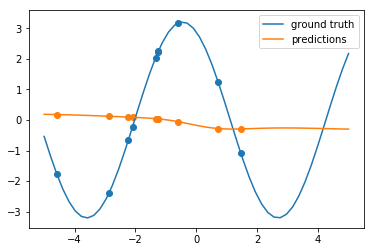

In [7]:
mesh = np.linspace(-5, 5)
p = np.random.uniform(-5, 5, size=(10, 1))
mesh_preds = model(torch.from_numpy(mesh[:, None]).float()).detach().numpy()
p_preds = model(torch.from_numpy(p).float()).detach().numpy()

plt.plot(mesh, f_T(mesh), label='ground truth')
plt.scatter(p, f_T(p))
plt.plot(mesh, mesh_preds, label='predictions')
plt.scatter(p, p_preds)
plt.legend(loc='best')
plt.show()

In [0]:
def new_task():
    a = np.random.uniform(low=0.1, high=5.0)
    b = np.random.uniform(low=0, high=2*np.pi)
    return lambda x: a * np.sin(x + b)

In [0]:
def take_n_steps(p, model, optim, f_T, n, retain_graph=False, create_graph=False):
    p = torch.from_numpy(p).float()
    labels = f_T(p)
    
    for _ in range(n):
        optim.zero_grad()
        loss = mse(model(p), labels)
        loss.backward(retain_graph=retain_graph, create_graph=create_graph)
        optim.step()

In [0]:
def view_losses(losses, split_interval=100):
    d = torch.split(torch.from_numpy(np.array([x.detach() for x in losses])), split_interval)
    mean_losses = [x.mean() for x in d]
    intervals = [split_interval * i for i in range(len(mean_losses))]
    
    plt.plot(intervals, mean_losses)
    plt.title('Model Test Loss (averaged every {} iterations)'.format(split_interval))
    plt.show()

# Reptile

In [88]:
model = nn.Sequential(nn.Linear(1, 64),
                      nn.ReLU(),
                      nn.Linear(64, 64),
                      nn.ReLU(),
                      nn.Linear(64, 1))
mse = nn.MSELoss()
reptile_losses = []

for i in range(6000):
    # meta model + Adam optimizer
    task_model = copy.deepcopy(model)
    optim = torch.optim.Adam(task_model.parameters())
    
    # meta train
    f_T = new_task()
    p = np.random.uniform(-5, 5, size=(10, 1))
    take_n_steps(p, task_model, optim, f_T, 32) # 32 steps
    
    # meta test - use entire interval
    ptest = torch.from_numpy(np.linspace(-5, 5)[:, None]).float()
    test_loss = mse(task_model(ptest), f_T(ptest))
    reptile_losses.append(test_loss)
        
    # param update
    for old, new in zip(model.parameters(), task_model.parameters()):
        old.data.add_(1e-2 * (new.data - old.data))
        
    if i % 500 == 0:
        print("Iteration %d: %.2f" % (i, reptile_losses[-1]))

Iteration 0: 6.83
Iteration 500: 4.32
Iteration 1000: 1.00
Iteration 1500: 3.84
Iteration 2000: 5.92
Iteration 2500: 0.93
Iteration 3000: 0.42
Iteration 3500: 2.28
Iteration 4000: 0.26
Iteration 4500: 2.27
Iteration 5000: 0.01
Iteration 5500: 1.06


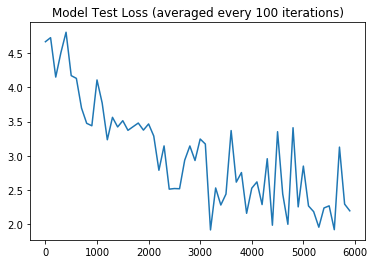

In [89]:
view_losses(reptile_losses, split_interval=100)

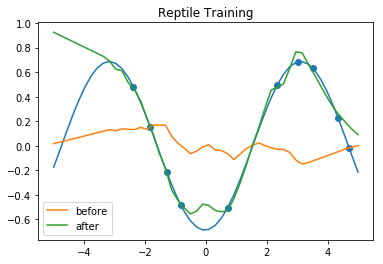

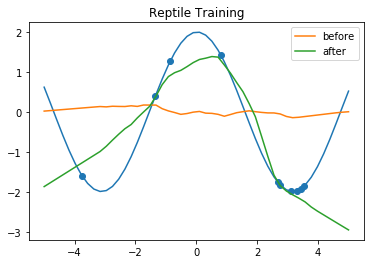

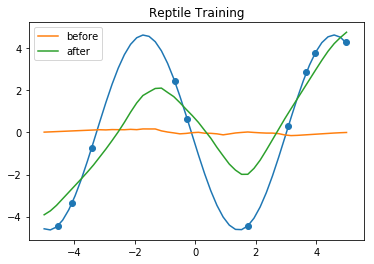

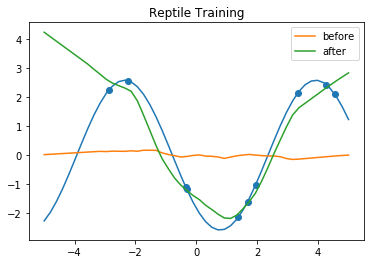

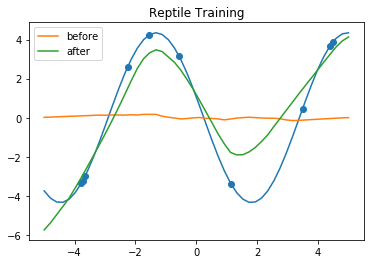

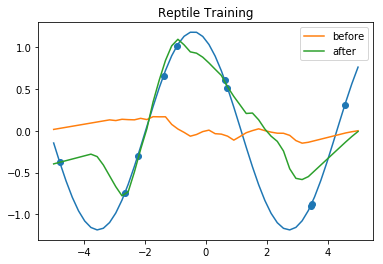

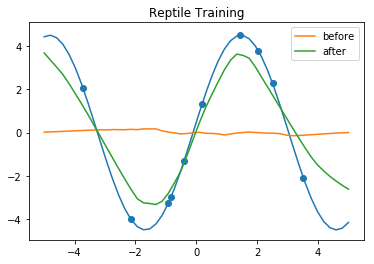

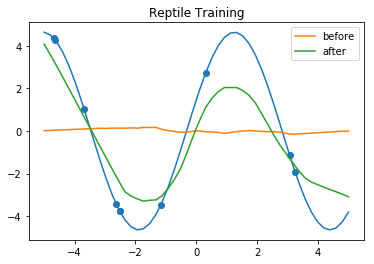

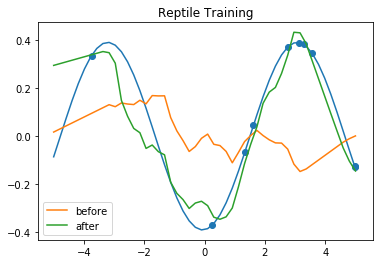

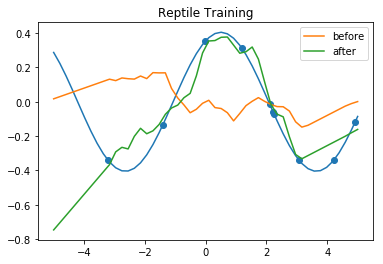

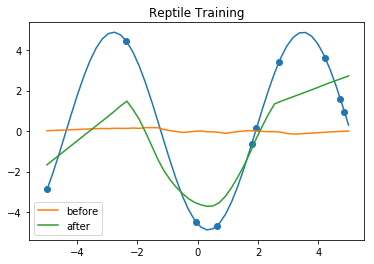

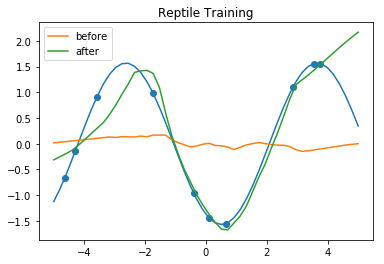

In [90]:
for _ in range(12):
    x = np.linspace(-5, 5)
    inter_x = torch.from_numpy(x[:, None]).float()
    p = np.random.uniform(-5, 5, size=(10, 1))

    f_T = new_task()
    task_model = copy.deepcopy(model)
    optim = torch.optim.Adam(task_model.parameters())
    take_n_steps(p, task_model, optim, f_T, 32)

    before_train = model(inter_x).detach().numpy()
    after_train = task_model(inter_x).detach().numpy()

    plt.plot(x, f_T(x))
    plt.scatter(p, f_T(p))

    plt.plot(x, before_train, label='before')
    plt.plot(x, after_train, label='after')
    plt.title("Reptile Training")
    plt.legend()
    plt.show()

# MAML

In [80]:
model = nn.Sequential(nn.Linear(1, 64),
                      nn.ReLU(),
                      nn.Linear(64, 64),
                      nn.ReLU(),
                      nn.Linear(64, 1))
mse = nn.MSELoss()
main_optimizer = torch.optim.Adam(model.parameters())
maml_losses = []

# MAML requires # of tasks for the 'inner loop' 
n_tasks = 5

# outter loop
for i in range(1200):
    meta_train_data = []
    
    # inner loop
    main_optimizer.zero_grad()
    for _ in range(n_tasks):
        task_model = copy.deepcopy(model)
        optim = torch.optim.Adam(task_model.parameters())
        
        # sample task 
        f_T = new_task()

        # meta train - retain & create graph for 2nd order derivatives 
        p = np.random.uniform(-5, 5, size=(10, 1))
        take_n_steps(p, task_model, optim, f_T, 32, retain_graph=True, create_graph=True)

        # meta test
        ptest = torch.from_numpy(np.linspace(-5, 5)[:, None]).float()
        mtest_loss = mse(task_model(ptest), f_T(ptest)) 
        mtest_loss.backward(retain_graph=True, create_graph=True)
        maml_losses.append(mtest_loss)

        # add/record meta gradients 
        for p_old, p_new in zip(model.parameters(), task_model.parameters()):
            p_old.grad = (p_new.grad + p_old.grad) if (p_old.grad is not None) else p_new.grad
        
    # backprop the mean value of task gradients
    for p in model.parameters():
        p.grad /= n_tasks
    main_optimizer.step()
    
    if (i+1) % 500 == 0:
        print("Iteration %d: %.2f" % (i, maml_losses[-1]))

Iteration 499: 2.62
Iteration 999: 0.32


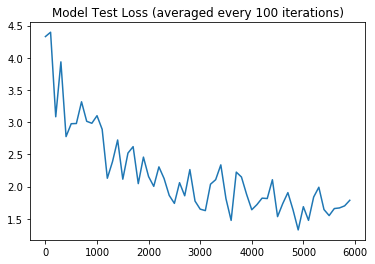

In [81]:
view_losses(maml_losses, split_interval=100)

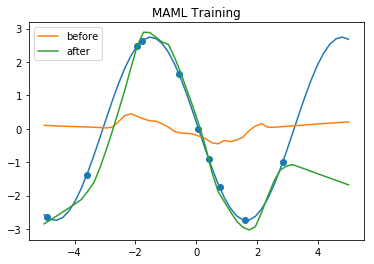

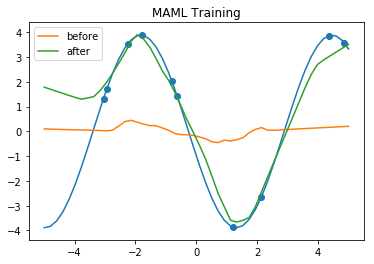

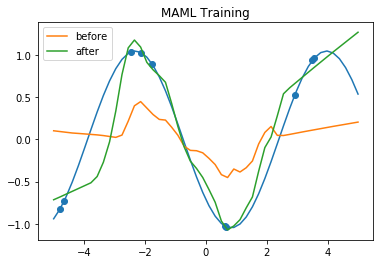

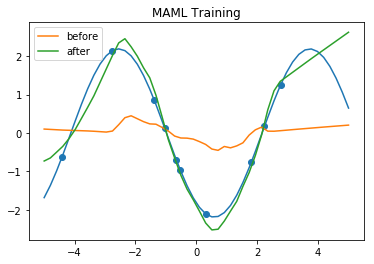

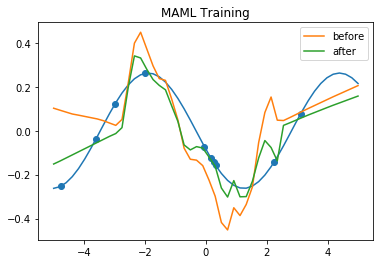

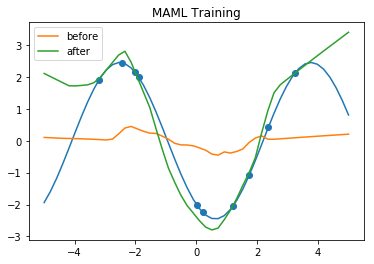

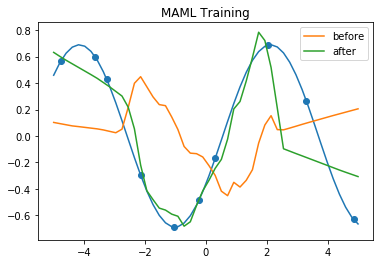

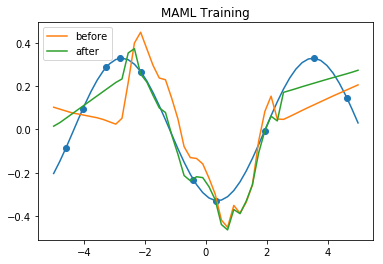

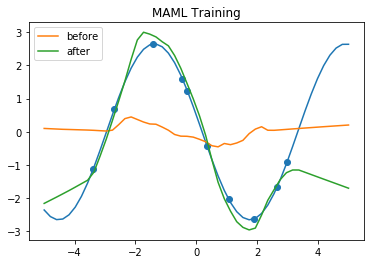

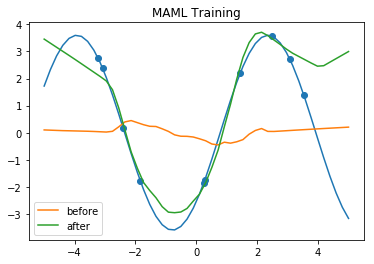

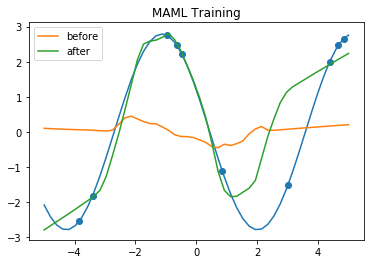

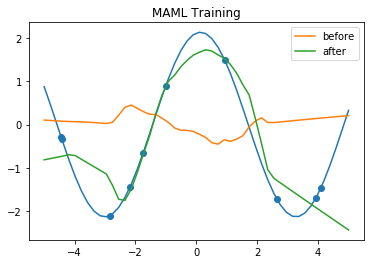

In [82]:
for _ in range(12):
    x = np.linspace(-5, 5)
    inter_x = torch.from_numpy(x[:, None]).float()
    p = np.random.uniform(-5, 5, size=(10, 1))

    f_T = new_task()
    task_model = copy.deepcopy(model)
    optim = torch.optim.Adam(task_model.parameters())
    take_n_steps(p, task_model, optim, f_T, 32)

    before_train = model(inter_x).detach().numpy()
    after_train = task_model(inter_x).detach().numpy()

    plt.plot(x, f_T(x))
    plt.scatter(p, f_T(p))

    plt.plot(x, before_train, label='before')
    plt.plot(x, after_train, label='after')
    plt.title("MAML Training")
    plt.legend()
    plt.show()

# FOMAML

In [83]:
model = nn.Sequential(nn.Linear(1, 64),
                      nn.ReLU(),
                      nn.Linear(64, 64),
                      nn.ReLU(),
                      nn.Linear(64, 1))
mse = nn.MSELoss()
main_optimizer = torch.optim.Adam(model.parameters())
losses = []

# MAML requires # of tasks for the 'inner loop' 
n_tasks = 5

# outter loop
for i in range(1200):
    meta_train_data = []
    
    # inner loop
    main_optimizer.zero_grad()
    for _ in range(n_tasks):
        task_model = copy.deepcopy(model)
        optim = torch.optim.Adam(task_model.parameters())
        
        # sample task 
        f_T = new_task()

        # meta train
        p = np.random.uniform(-5, 5, size=(10, 1))
        take_n_steps(p, task_model, optim, f_T, 32)

        # meta test
        ptest = torch.from_numpy(np.linspace(-5, 5)[:, None]).float()
        mtest_loss = mse(task_model(ptest), f_T(ptest)) 
        mtest_loss.backward()
        losses.append(mtest_loss)

        # add/record meta gradients 
        for p_old, p_new in zip(model.parameters(), task_model.parameters()):
            p_old.grad = (p_new.grad + p_old.grad) if (p_old.grad is not None) else p_new.grad
        
    # backprop the mean value of task gradients
    for p in model.parameters():
        p.grad /= n_tasks
    main_optimizer.step()
    
    if (i+1) % 500 == 0:
        print("Iteration %d: %.2f" % (i, losses[-1]))

Iteration 499: 2.82
Iteration 999: 3.64


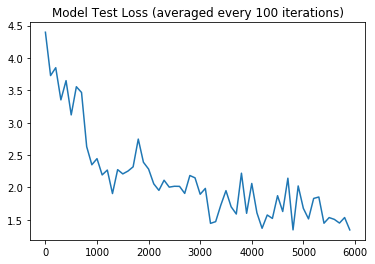

In [84]:
view_losses(losses, split_interval=100)

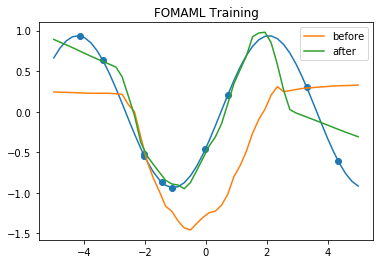

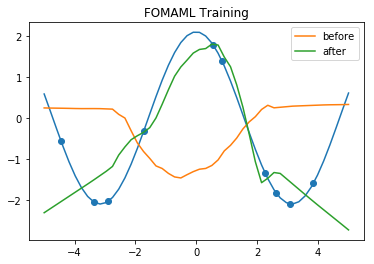

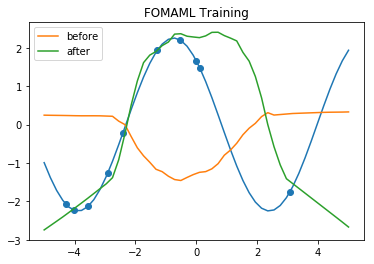

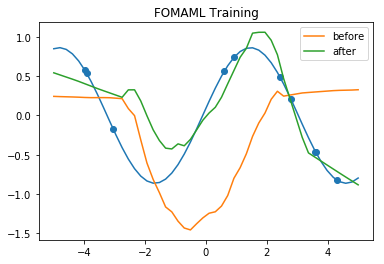

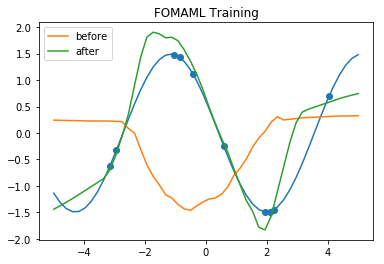

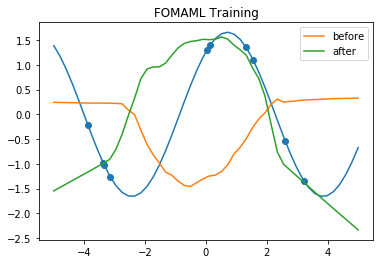

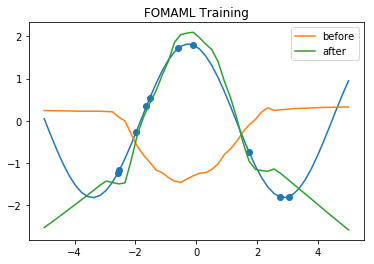

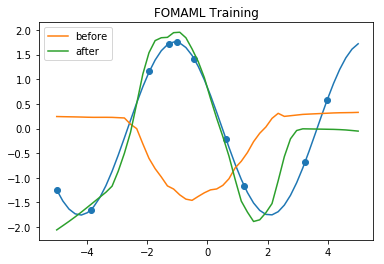

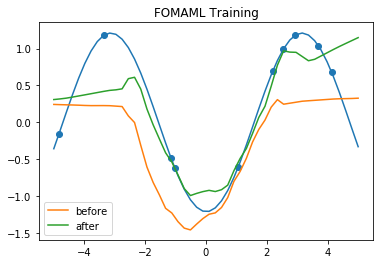

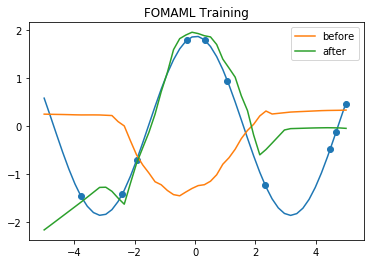

In [86]:
for _ in range(10):
    x = np.linspace(-5, 5)
    inter_x = torch.from_numpy(x[:, None]).float()
    p = np.random.uniform(-5, 5, size=(10, 1))

    f_T = new_task()
    task_model = copy.deepcopy(model)
    optim = torch.optim.Adam(task_model.parameters())
    take_n_steps(p, task_model, optim, f_T, 32)

    before_train = model(inter_x).detach().numpy()
    after_train = task_model(inter_x).detach().numpy()

    plt.plot(x, f_T(x))
    plt.scatter(p, f_T(p))

    plt.plot(x, before_train, label='before')
    plt.plot(x, after_train, label='after')
    plt.title("FOMAML Training")
    plt.legend()
    plt.show()